In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import astropy.units as u
from astroquery.hips2fits import hips2fits
from astropy.coordinates import Longitude, Latitude, Angle

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils.sersic_functions import sersic_profile, generate_random_pos

In [44]:
df = pd.read_csv("../data/SERSIC/delight_sersic.csv", index_col='oid', dtype={'objID': 'Int64'})

In [45]:
ser_columns = [
    "objID", "host_ra", "host_dec", "hostsize", "dx", "dy",
    "rSerRadius", "rSerAb", "rSerPhi", "rSerChisq", "rSerRa", "rSerDec",
]

In [46]:
df_sersic = (
    df.dropna(subset=ser_columns)                        # Eliminamos ejemplos con nan
      .loc[~(df[ser_columns] == -999).any(axis=1)]       # Eliminamos ejemplos con -999
      [ser_columns]
      .drop_duplicates(subset="objID")                   # Eliminamos galaxias duplicadas
)

In [47]:
df_sersic

,objID,host_ra,host_dec,hostsize,dx,dy,rSerRadius,rSerAb,rSerPhi,rSerChisq,rSerRa,rSerDec
oid,,,,,,,,,,,,
ZTF19acaqqxo,160611556472747538,155.647290,43.847310,66.722168,-6.988346,-23.025632,9.03469,0.530315,85.152397,3.442620,155.647339,43.847298
ZTF19acbpxwt,186802409857776654,240.985580,65.671610,11.103163,7.794265,6.392219,2.78418,0.588130,59.962700,1.619010,240.985764,65.671585
ZTF19acbpzir,204222826241433588,282.625080,80.185580,15.026858,-0.639558,-12.653639,3.64761,0.785985,50.942001,1.488890,282.625214,80.185600
ZTF19acbwiry,143772452174004405,245.217375,29.811500,6.210382,2.071523,8.778189,1.66751,0.724595,40.693100,1.258510,245.217407,29.811502
ZTF19accdaqi,142401513500480472,151.350090,28.666630,17.474194,-1.807320,10.898462,3.81206,0.681890,-48.438400,2.436470,151.350082,28.666599
...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18aceckot,118370622996699212,62.299708,8.648750,46.701057,-21.570230,20.151215,9.05507,0.724950,-32.208900,210.123993,62.299549,8.649583
ZTF19aaydpzi,77202105141399104,210.514205,-25.659288,52.289154,38.494181,30.911253,6.45473,0.515725,49.031799,38.676701,210.514084,-25.659275
ZTF19acapeun,145180449975404946,44.997188,30.986714,33.356407,56.451084,-24.277655,6.52419,0.550212,52.672600,3.608650,44.997478,30.987041


### EDA

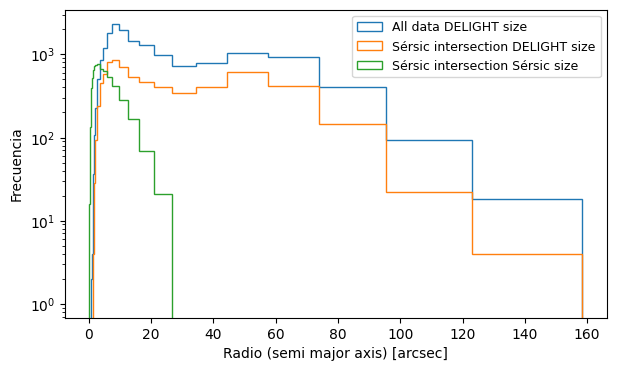

In [48]:
bins = np.logspace(-1,2.2,30)

plt.figure(figsize=(7,4))
plt.hist(df['hostsize'], bins=bins, histtype="step", label="All data DELIGHT size")
plt.hist(df_sersic["hostsize"], bins=bins, histtype="step", label ="Sérsic intersection DELIGHT size")
plt.hist(df_sersic["rSerRadius"], bins=bins, histtype="step", label = "Sérsic intersection Sérsic size")

plt.legend(fontsize=9)
plt.yscale("log")
#plt.xscale("log")

plt.ylabel("Frecuencia")
plt.xlabel("Radio (semi major axis) [arcsec]")
plt.show()

299.97480010986357
32.59961986541748
46.83246297066452
42.731567230019174


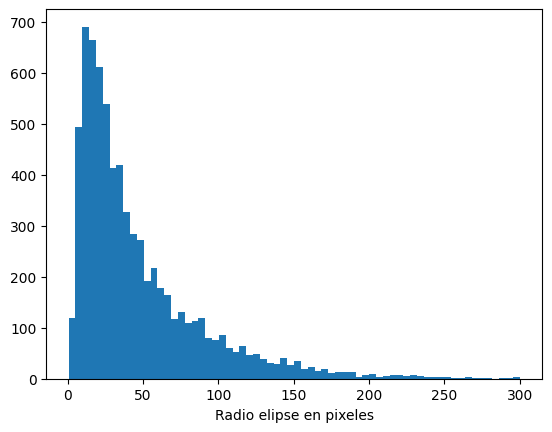

In [49]:
# Radio de las elipses de Sersic (3 veces el radio) en pixeles
# En este caso seleccionamos 210 pixeles de radio

print(df_sersic["rSerRadius"].max()*3/0.25)
print(df_sersic["rSerRadius"].median()*3/0.25)
print(df_sersic["rSerRadius"].mean()*3/0.25)
print(df_sersic["rSerRadius"].std()*3/0.25)

plt.hist(df_sersic["rSerRadius"]*3/0.25, bins="auto")
plt.xlabel("Radio elipse en pixeles")
plt.show()

In [50]:
def assign_sersic_category(df, pixel_scale=0.25, max_radius=3):
    """
    Asigna una categoría [1, 2, 3, 4, 5] a cada fila del dataframe según
    en qué anillo elíptico cae la posición de la supernova (SN) respecto al perfil de Sérsic.

    Parámetros:
    - df: pandas.DataFrame con columnas 'rSerRadius', 'rSerAb', 'rSerPhi', 'dx', 'dy'
    - pixel_scale: escala en arcsec/pixel
    - max_radius: radio máximo de los anillos elípticos (por defecto 4)

    Devuelve:
    - df con nueva columna 'sersic_category'
    """
    categories = []

    for _, row in df.iterrows():
        Re_arcsec = row["rSerRadius"]
        b_over_a = row["rSerAb"]
        theta_sersic = row["rSerPhi"]
        dx, dy = row["dx"], row["dy"]

        # Centro fijo (coincide con imagen de 240x240)
        x_center = y_center = 134  # 240//2 - 1

        # Convertir radios a pixeles
        Re_pix = Re_arcsec / pixel_scale
        A_pix = Re_pix
        B_pix = A_pix * b_over_a

        # Posición real de la SN
        x_star = x_center + dx
        y_star = y_center + dy

        dx_sn = x_star - x_center
        dy_sn = y_star - y_center

        # Rotar para alinear con el eje mayor
        theta_rad = np.deg2rad(theta_sersic)
        cos_theta = np.cos(theta_rad)
        sin_theta = np.sin(theta_rad)

        x_rot = dx_sn * cos_theta + dy_sn * sin_theta
        y_rot = -dx_sn * sin_theta + dy_sn * cos_theta

        # Calcular radio elíptico
        r_elliptical = np.sqrt((x_rot / A_pix)**2 + (y_rot / B_pix)**2)

        # Clasificar
        for r in range(1, max_radius + 1):
            if r_elliptical <= r:
                categories.append(r)
                break
        else:
            categories.append(max_radius + 1)

    df = df.copy()
    df["sersic_category"] = categories
    return df

In [51]:
df_sersic = assign_sersic_category(df_sersic)

In [52]:
df_sersic["sersic_category"].value_counts()

sersic_category
1    3367
2    2171
4     829
3     737
Name: count, dtype: int64

### Funciones

In [8]:
def get_sdss_img(df, id, fov, size):
    
    ra,dec = np.float64(df.iloc[id][["host_ra","host_dec"]].values)

    r = hips2fits.query(
        hips="CDS/P/PanSTARRS/DR1/r",
        width=size,
        height=size,
        ra=Longitude(ra * u.deg),
        dec=Latitude(dec * u.deg),
        fov=Angle(fov  * u.deg),
        projection="TAN",
        get_query_payload=False,
        format='fits',
        )

    r = r[0].data.byteswap().newbyteorder()
    r = np.nan_to_num(r, 0)

    # Las imagenes de DELIGHT estan con estas transformaciones
    r = np.rot90(r, k=1)
    r = np.flipud(r)
    return r

In [22]:
def plot_galaxy_and_sersic(df, idx, Ie=1.0, n=4, scale_factor=3):

    row = df.iloc[idx]
    image_data = get_sdss_img(df, idx, fov=240*0.25/3600, size=240) #Imagen de 240x240 con resolucion 0.25 arcsec/pix

    # Coordenadas del centro
    x_center, y_center = image_data.shape[0]//2 -1 , image_data.shape[1]//2 -1

    # Parámetros de Sérsic
    Re_arcsec = row["rSerRadius"]
    b_over_a = row["rSerAb"]
    theta_sersic = row["rSerPhi"]  # Usar el ángulo original
    pixel_scale = 0.25
    Re_pix = Re_arcsec / pixel_scale
    A_pix = Re_pix
    B_pix = A_pix * b_over_a

    # Generar perfil de Sérsic
    sersic_img = sersic_profile(
        image_shape=image_data.shape,
        x_center=x_center, y_center=y_center,
        Re_arcsec=Re_arcsec,
        b_over_a=b_over_a,
        theta_deg=theta_sersic,  
        pixel_scale=pixel_scale,
        Ie=Ie,
        n=n
    )

    # vemos las posiciones que tomo la supernova en 1000 iteraciones
    random_pos = []
    for i in range(2):
        pos = generate_random_pos(sersic_radius = Re_arcsec, 
                                    sersic_ab = b_over_a, 
                                    sersic_phi =theta_sersic, 
                                    img_size = image_data.shape[0])
        random_pos.append(pos) 

    random_pos =  np.array(random_pos) + x_center
    x_iter = random_pos[:, 1]
    y_iter = random_pos[:, 0]


    fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

    dx, dy = row[["dx","dy"]].values

    x_star = x_center + dy
    y_star = y_center + dx

    # Imagen real con elipse
    ax1 = axes[0]

    # Posicion SN real
    ax1.scatter(x_star, y_star,
                marker='*',         
                color='yellow',     
                s=500,              
                edgecolor='black')  
    
    ax1.imshow(image_data, cmap='gray',
               vmin=np.percentile(image_data, 1),
               vmax=np.percentile(image_data, 99))
    
    ellipse1 = Ellipse((x_center, y_center),
                       width=B_pix * 2 * scale_factor,
                       height=A_pix * 2 * scale_factor,
                       angle=-theta_sersic,  
                       edgecolor='red', facecolor='none', lw=2)
    ax1.add_patch(ellipse1)

    for r in [1, 2, 3]:
        ellipse = Ellipse((x_center, y_center),
                        width=B_pix * 2 * r,
                        height=A_pix * 2 * r,
                        angle=-theta_sersic,
                        edgecolor='red',
                        facecolor='none',
                        lw=1.5,
                        linestyle='--' if r < 3 else '-')
        ax1.add_patch(ellipse)

    ax1.set_title("Galaxia con perfil elíptico")
    ax1.axis('off')

    # Mostrar perfil de Sérsic
    ax2 = axes[1]
    im = ax2.imshow(sersic_img, cmap='viridis', vmin=0, vmax=300)
    ellipse2 = Ellipse((x_center, y_center),
                       width=B_pix * 2 * scale_factor,
                       height=A_pix * 2 * scale_factor,
                       angle=-theta_sersic, 
                       edgecolor='red', facecolor='none', lw=2)
    
    ax2.add_patch(ellipse2)

    # Posciones SN arbitrarias
    for r in [1, 2, 3]:
        ellipse = Ellipse((x_center, y_center),
                        width=B_pix * 2 * r,
                        height=A_pix * 2 * r,
                        angle=-theta_sersic,
                        edgecolor='red',
                        facecolor='none',
                        lw=1.5,
                        linestyle='--' if r < 3 else '-')
        ax2.add_patch(ellipse)

    ax2.set_title("Perfil de Sérsic (n=4)")
    ax2.axis('off')
    fig.colorbar(im, ax=ax2, label='Intensidad')

    ax3 = axes[2]
    hist, _, _ = np.histogram2d(x_iter, y_iter, bins=240, range=[[0, 240], [0, 240]])
    im3 = ax3.imshow(hist.T, cmap='hot', interpolation='nearest')
    ax3.set_title('Posiciones supernova 1000 sampleos arbitrarios')
    ax3.axis('off')
    fig.colorbar(im3, ax=ax3, label='Frecuencia')


    plt.tight_layout()
    plt.show()

    return sersic_img

### Plots

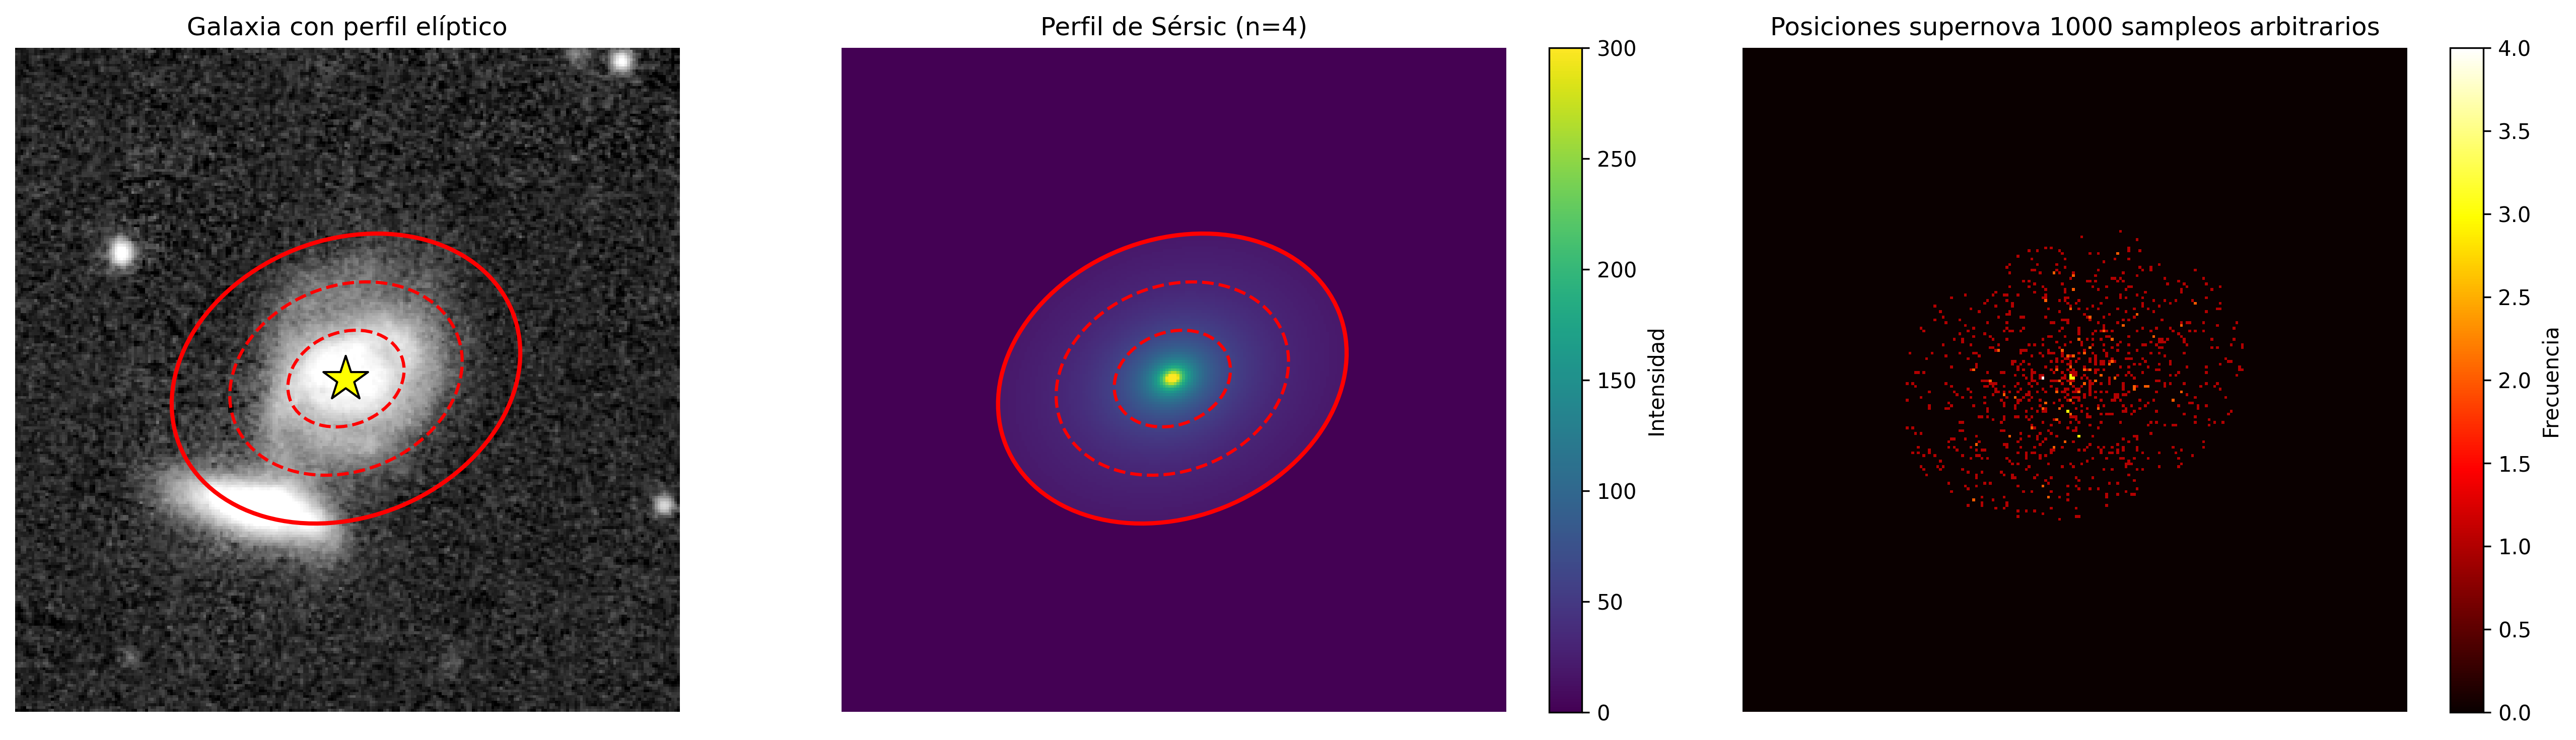

In [ ]:
sersic_prof = plot_galaxy_and_sersic(df = df_sersic,
                                     idx = 14) 

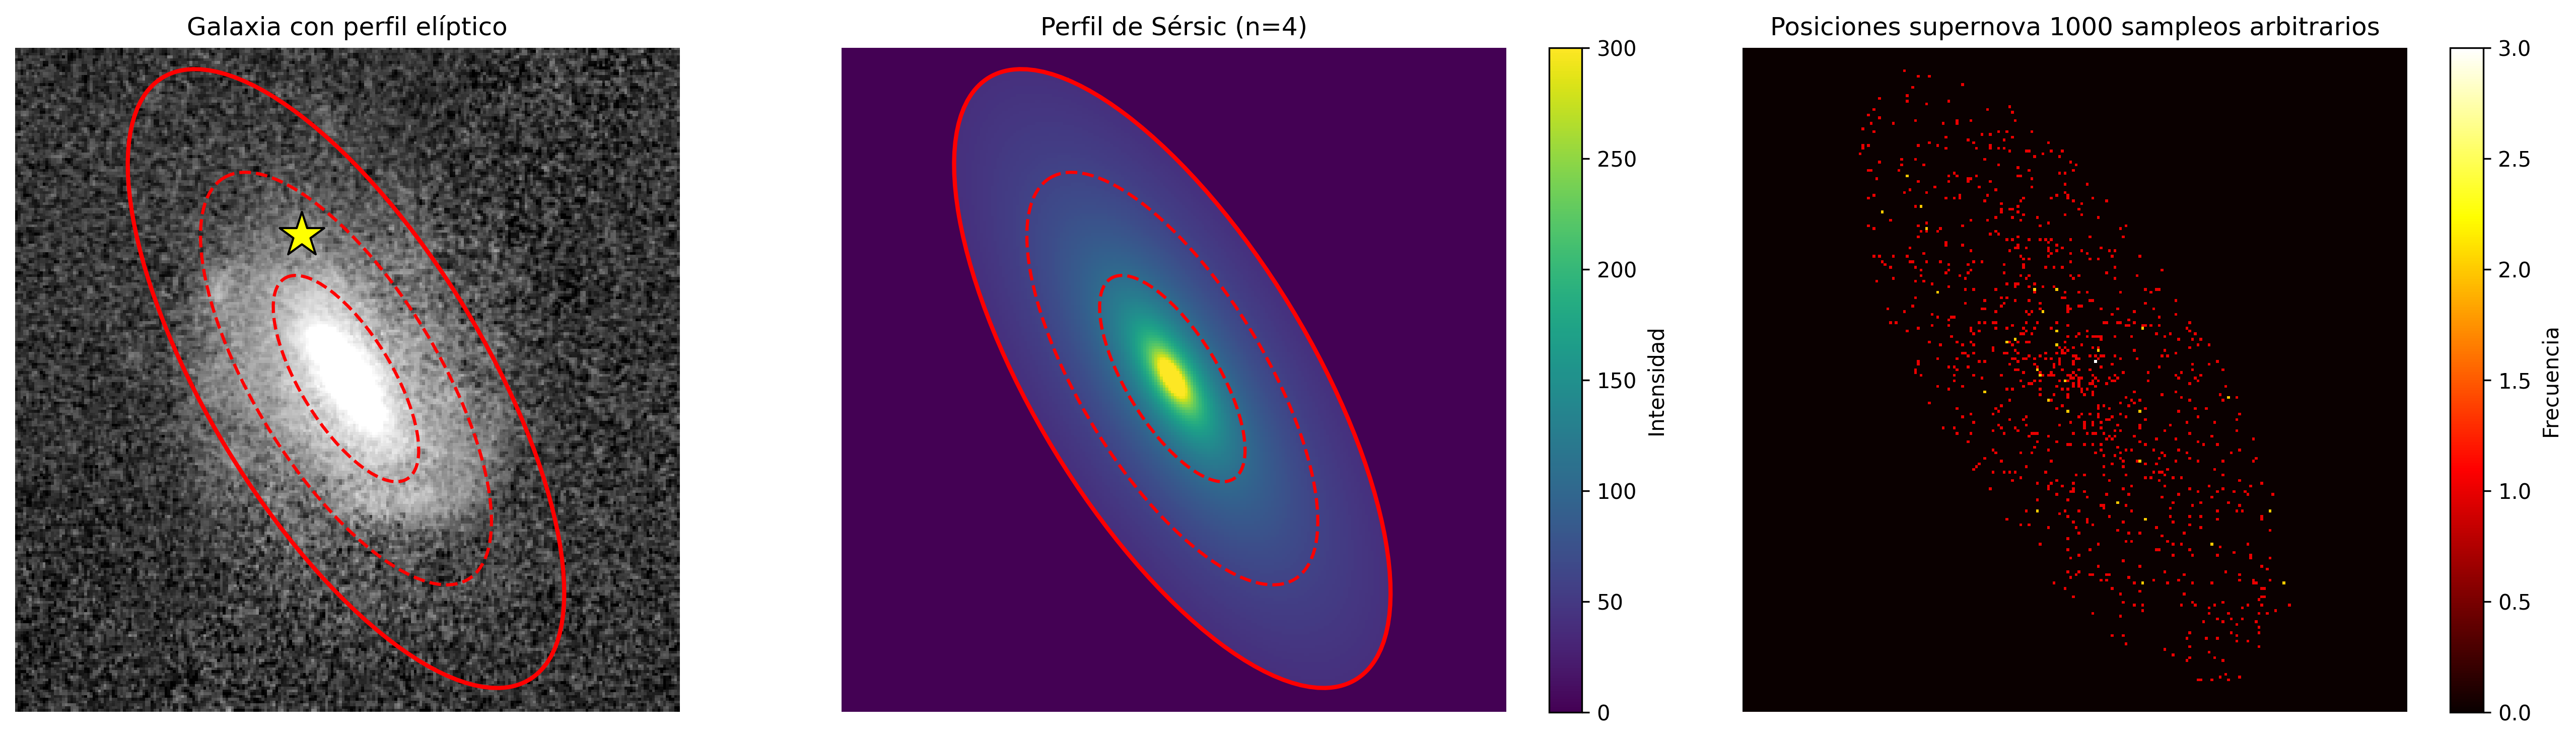

In [15]:
sersic_prof = plot_galaxy_and_sersic(df = df_sersic,
                                     idx = 40) 

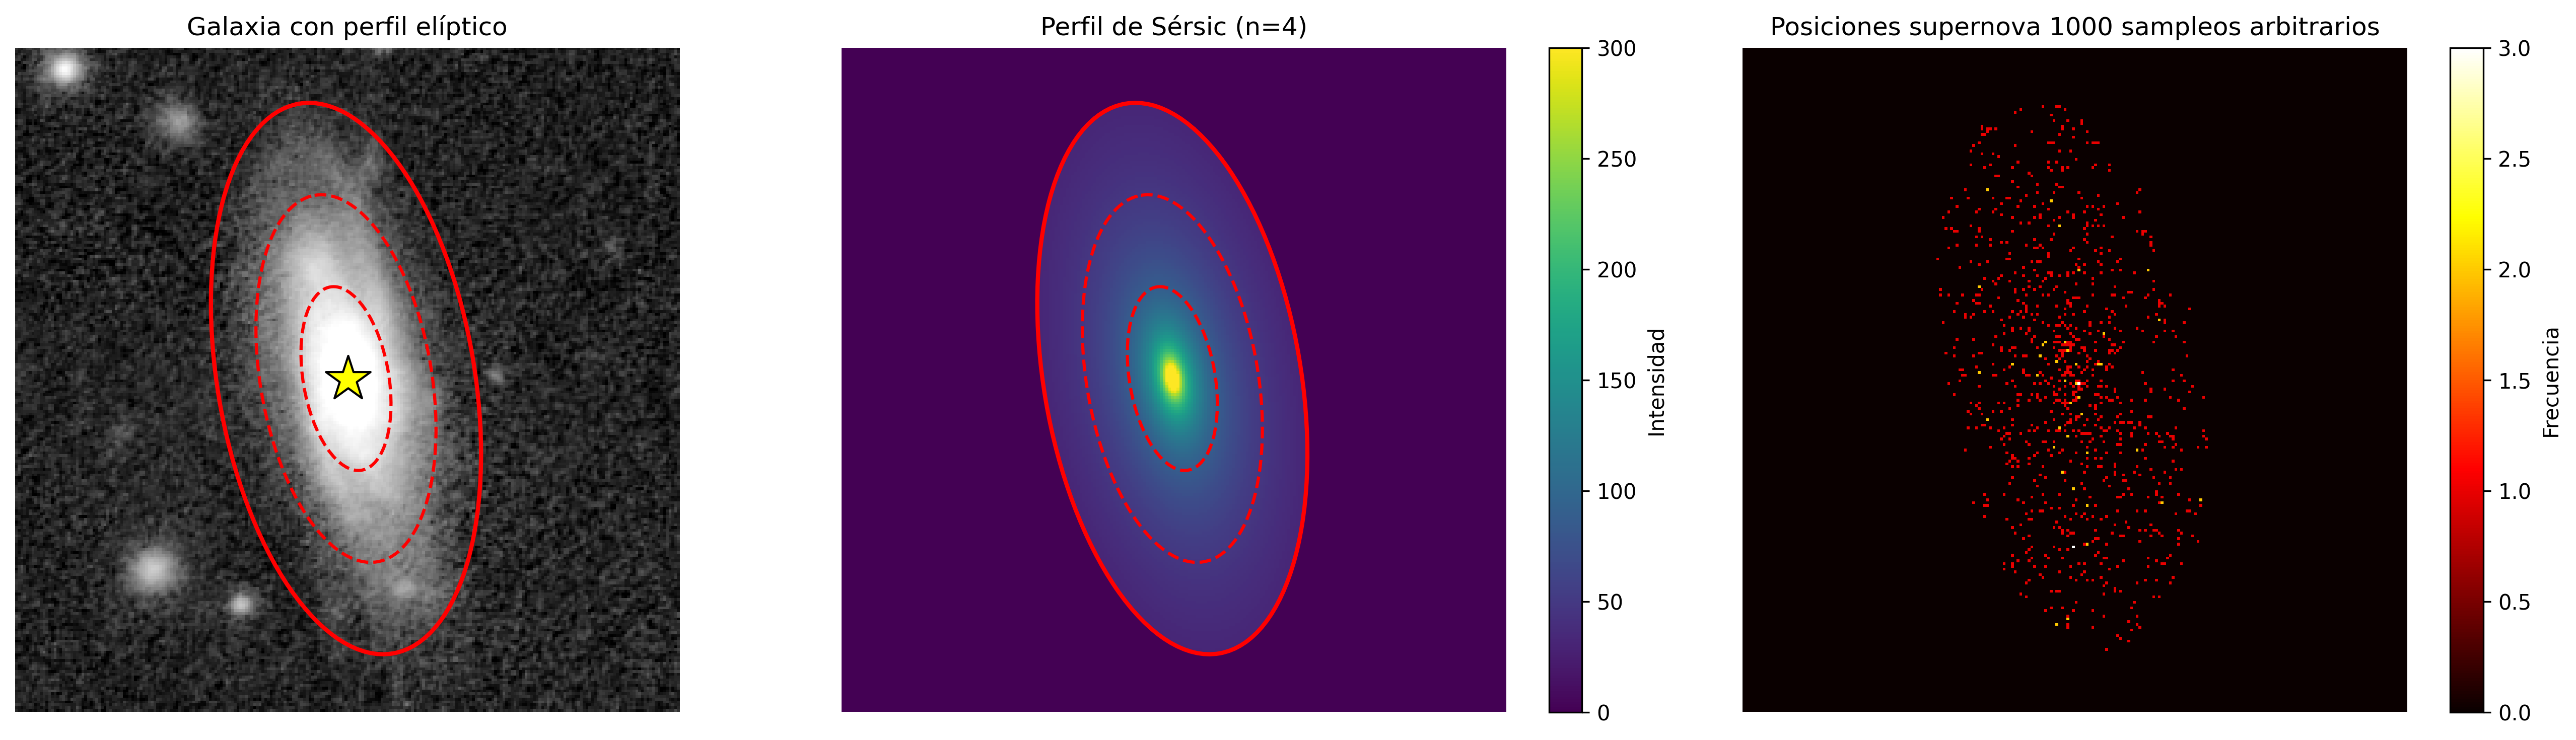

In [16]:
sersic_prof = plot_galaxy_and_sersic(df = df_sersic,
                                     idx = 25) 

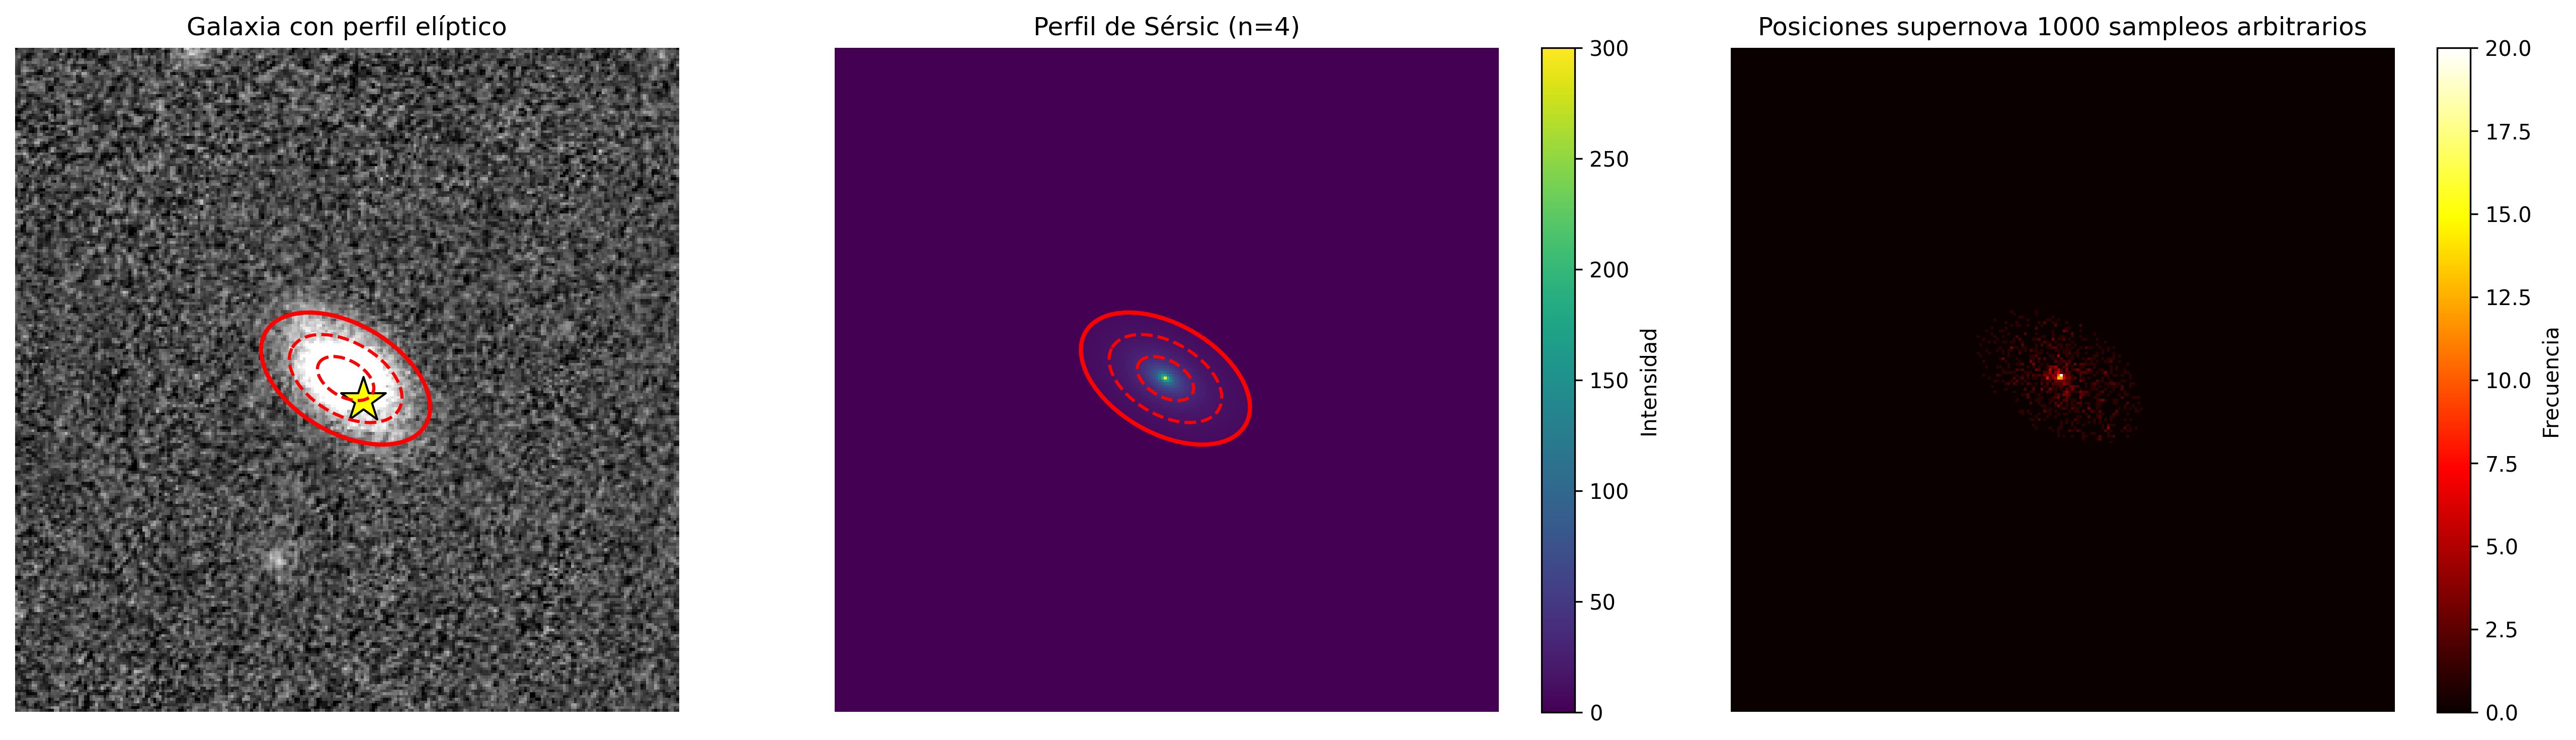

In [17]:
sersic_prof = plot_galaxy_and_sersic(df = df_sersic,
                                     idx = 1) 